In [1]:
import finesse.virgo

from finesse.analysis.actions import RunLocks, CheckLinearity, GetErrorSignals
from finesse.virgo.actions import DARM_RF_to_DC

import matplotlib.pyplot as plt

finesse.init_plotting()
finesse.configure(progress_bars=True)

These examples are to show how to use this package with typical commissioning work:

0. Create a pre-tuned Virgo file
1. changing locks
2. pretuned file, change roc, pretune, optimize, run locks
3. plotting error signals
4. showing sensing matrix
5. plotting QNLS
6. plotting DARM TF
6. plotting DoFs

Useful prints:
1. print_lengths()
2. print_powers()
3. print_tunings()
4. print_settings()
5. print_locks()
6. print_thermal_state()

## Ex. 0: Create a pre-tuned Virgo file
This example shows how to create a pre-tuned Virgo file which will be used for the remainder of the notebook.

Before tuning
┌─────────────────────────────────────────────────┐
│- Arm lengths [m]:                               │
│  LN   = 2999.8180   LW = 2999.7880              │
├─────────────────────────────────────────────────┤
│- Michelson and recycling lengths [m]:           │
│  ln   = 6.0152      lw       = 5.7851           │
│  lpr  = 6.0513      lsr      = 6.0509           │
│  lMI  = 5.9001      lSchnupp = 0.2301           │
│  lPRC = 11.9515     lSRC     = 11.9511          │
├─────────────────────────────────────────────────┤
│- Associated cavity frequencies [Hz]:            │
│  fsrN   = 49968.44    fsrW   = 49968.94         │
│  fsrPRC = 12542050.98 fsrSRC = 12542480.59      │
│                                                 │
│- Modulation sideband frequencies [MHz]:         │
│  f6     = 6.270777     f8     = 8.361036        │
│  f56     = 56.436993                            │
├─────────────────────────────────────────────────┤
│- Check frequency match [MHz]:                   

PRCL_lock ✗ MICH_lock ✗ CARM_lock ✗ DARM_rf_lock ✗ SRCL_lock ✗ |##########| 10000/10000

DARM_rf_lock ✗ |##########| 10000/10000

DARM_dc_lock ✗ |##########| 10000/10000

After DARM DC lock
┌─────────────────────────────────────────────────┐
│- Arm lengths [m]:                               │
│  LN   = 2999.8180   LW = 2999.7880              │
├─────────────────────────────────────────────────┤
│- Michelson and recycling lengths [m]:           │
│  ln   = 6.0152      lw       = 5.7851           │
│  lpr  = 6.0518      lsr      = 6.0518           │
│  lMI  = 5.9001      lSchnupp = 0.2301           │
│  lPRC = 11.9520     lSRC     = 11.9520          │
├─────────────────────────────────────────────────┤
│- Associated cavity frequencies [Hz]:            │
│  fsrN   = 49968.44    fsrW   = 49968.94         │
│  fsrPRC = 12541554.00 fsrSRC = 12541554.00      │
│                                                 │
│- Modulation sideband frequencies [MHz]:         │
│  f6     = 6.270777     f8     = 8.361036        │
│  f56     = 56.436993                            │
├─────────────────────────────────────────────────┤
│- Check frequency match [MHz]:              

Intent-preserving regeneration of KatScript for operations has not been implemented yet. These have instead been generated using default formatting (this does not affect the validity of the generated KatScript).
Intent-preserving regeneration of KatScript for nonsingular commands has not been implemented yet. These have instead been generated using default formatting (this does not affect the validity of the generated KatScript).


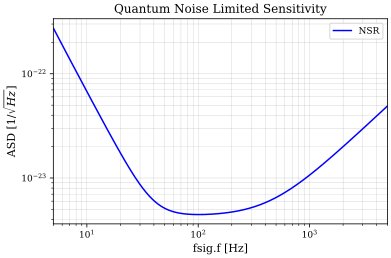

In [2]:
# 0. This creates a pretuned Virgo file using the common file.
#   (to be used by the following examples)
# TODO: how to make silent?
virgo = finesse.virgo.Virgo()

print('Before tuning')
virgo.print_lengths()
virgo.print_powers()

# step 1: adjust the cavity lengths
virgo.adjust_PRC_length()
virgo.adjust_SRC_length()

# step 2: pretune
virgo.pretune()

# step 3: optimize demodulation phases
virgo.optimize_demodulation_phase()

# step 4: optimize lock gains
virgo.optimize_lock_gains()

# step 5: run locks
virgo.model.run(RunLocks(method="newton"))
virgo.model.run(DARM_RF_to_DC())

print('After DARM DC lock')
virgo.print_lengths()
virgo.print_powers()

virgo.plot_QNLS()

# save configuration for future reference
virgo.model.unparse_file('pretuned_virgo.kat')

## Ex. 1: Changing Locks
This example shows how to work with locks:
1. Display lock information
2. Toggle a lock
3. Changing lock gain

In [3]:
# lock information can be displayed
virgo.print_locks()

# locks can be turned on or off
virgo.model.DARM_dc_lock.enabled = False
virgo.model.DARM_rf_lock.enabled = True

# The lock gain can be set directly
virgo.model.DARM_rf_lock.gain = -0.007

 ╔═══════════════════════════════════════════════════════╗
 ║ Parameters for locks:                                 ║
 ╠═══════════════════════════════════════════════════════╣
 ║ Lock name      port     DOF      lock gain    enabled ║
 ║ PRCL_lock      B2_8_I   DC        -6.4e+01       True ║
 ║ MICH_lock      B2_56_Q  DC           2e+03       True ║
 ║ CARM_lock      B2_6_I   DC           -0.16       True ║
 ║ DARM_rf_lock   B1p_56_I DC         -0.0066      False ║
 ║ DARM_dc_lock   B1_DC    DC           -0.01       True ║
 ║ SRCL_lock      B2_56_I  DC        -3.8e+03       True ║
 ╟───────────────────────────────────────────────────────╢
 ║ Accuracies        [deg]            [m]            [W] ║
 ║ PRCL     :  0.000338346          1e-12        5.3e-06 ║
 ║ MICH     :   0.00338346          1e-11        9.1e-07 ║
 ║ CARM     :  3.38346e-06          1e-14        1.6e-05 ║
 ║ DARM     :  3.38346e-06          1e-14         0.0017 ║
 ║ SRCL     :     0.169173          5e-10        2.2e-05

## Ex. 2: Changing parameters with a pre-tuned script

 ╔═══════════════════════════════════════════════════════╗
 ║ Parameters for locks:                                 ║
 ╠═══════════════════════════════════════════════════════╣
 ║ Lock name      port     DOF      lock gain    enabled ║
 ║ PRCL_lock      B2_8_I   DC        -6.4e+01       True ║
 ║ MICH_lock      B2_56_Q  DC           2e+03       True ║
 ║ CARM_lock      B2_6_I   DC           -0.16       True ║
 ║ DARM_rf_lock   B1p_56_I DC         -0.0066      False ║
 ║ DARM_dc_lock   B1_DC    DC           -0.01       True ║
 ║ SRCL_lock      B2_56_I  DC        -3.8e+03       True ║
 ╟───────────────────────────────────────────────────────╢
 ║ Accuracies        [deg]            [m]            [W] ║
 ║ PRCL     :  0.000338346          1e-12        5.3e-06 ║
 ║ MICH     :   0.00338346          1e-11        9.1e-07 ║
 ║ CARM     :  3.38346e-06          1e-14        1.6e-05 ║
 ║ DARM     :  3.38346e-06          1e-14         0.0017 ║
 ║ SRCL     :     0.169173          5e-10        2.2e-05

PRCL_lock ✗ MICH_lock ✗ CARM_lock ✗ DARM_rf_lock ✗ SRCL_lock ✗ |##########| 10000/10000

DARM_rf_lock ✗ |##########| 10000/10000

DARM_dc_lock ✗ |##########| 10000/10000

<Axes: title={'center': 'Quantum Noise Limited Sensitivity'}, xlabel='fsig.f [Hz]', ylabel='ASD [1/$\\sqrt{Hz}$]'>

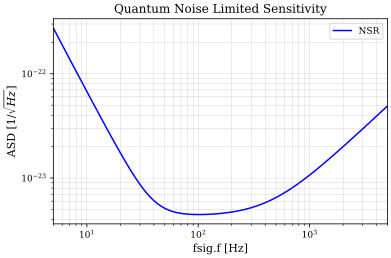

In [4]:
# 2. How to load a pretuned file, change a parameter (PR.Rc in this case)
#   and then get back to an operating point.

# load a pretuned file
virgo = finesse.virgo.Virgo('pretuned_virgo.kat')

# show status of locks
virgo.print_locks()

# switch back to the DARM RF lock since the pretuned file uses DARM DC lock
virgo.model.DARM_dc_lock.enabled = False
virgo.model.DARM_rf_lock.enabled = True

# change a parameter
virgo.model.PR.Rcx += 1
virgo.model.PR.Rcy += 1

# re-pretune again
virgo.pretune()

# re-optimize demodulation phases and lock gains
virgo.optimize_demodulation_phase()
virgo.optimize_lock_gains()

# run the locks to bring it back into a locked state
virgo.model.run(RunLocks(method="newton"))
virgo.model.run(DARM_RF_to_DC())

virgo.plot_QNLS()

## Ex. 3: Plot error signals

(<Figure size 768x576 with 6 Axes>,
 array([<Axes: xlabel='PRCL [deg]', ylabel='B2_8_I [W]'>,
        <Axes: xlabel='MICH [deg]', ylabel='B2_56_Q [W]'>,
        <Axes: xlabel='CARM [deg]', ylabel='B2_6_I [W]'>,
        <Axes: xlabel='DARM [deg]', ylabel='B1p_56_I [W]'>,
        <Axes: xlabel='DARM [deg]', ylabel='B1_DC [W]'>,
        <Axes: xlabel='SRCL [deg]', ylabel='B2_56_I [W]'>], dtype=object))

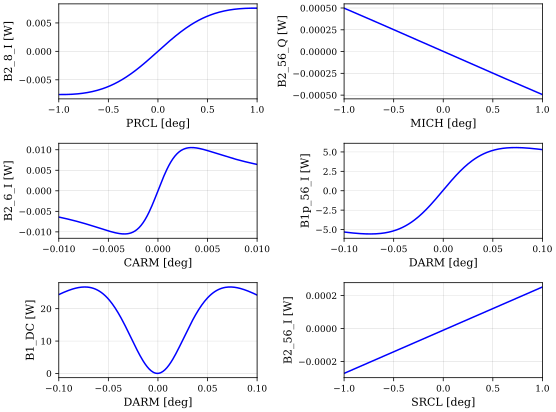

In [5]:
# one plot per lock
# virgo = finesse.virgo.Virgo()
# print(virgo.model.run(GetErrorSignals()).results)
# # virgo.model.run(CheckLinearity())
# virgo.make()
# print(virgo.model.run(GetErrorSignals()).results)
# virgo.model.run(CheckLinearity())
virgo.plot_error_signals()

## Ex. 4: Display the sensing matrix

In [6]:
# 4. Showing sensing matrix
print(virgo.get_sensing_matrix())

┌──────╥─────────┬──────────┬─────────┬─────────┬──────────┬──────────┬──────────┬──────────┐
│      ║ B2_8_I  │  B2_8_Q  │ B2_56_I │ B2_56_Q │  B2_6_I  │  B2_6_Q  │ B1p_56_I │ B1p_56_Q │
╞══════╬═════════╪══════════╪═════════╪═════════╪══════════╪══════════╪══════════╪══════════╡
│ PRCL ║   0.016 │  3.2E-12 │ -0.0031 │  0.0024 │  -0.0029 │  4.4E-05 │  5.5E-05 │ -0.00059 │
├──────╫─────────┼──────────┼─────────┼─────────┼──────────┼──────────┼──────────┼──────────┤
│ MICH ║ 3.8E-05 │  5.7E-08 │ 8.2E-06 │ -0.0005 │ -6.5E-06 │ -7.2E-05 │     0.53 │  0.00018 │
├──────╫─────────┼──────────┼─────────┼─────────┼──────────┼──────────┼──────────┼──────────┤
│ CARM ║    -4.5 │ -3.4E-06 │       5 │   -0.66 │      6.2 │  1.9E-08 │     0.42 │ -0.00078 │
├──────╫─────────┼──────────┼─────────┼─────────┼──────────┼──────────┼──────────┼──────────┤
│ DARM ║   0.016 │  1.3E-08 │  -0.018 │  0.0024 │   -0.023 │ -2.7E-07 │  1.5E+02 │  5.6E-06 │
├──────╫─────────┼──────────┼─────────┼─────────┼──────────┼

## Ex. 5: Plot the QNLS

/home/jon/miniconda3/envs/f3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jon/miniconda3/envs/f3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


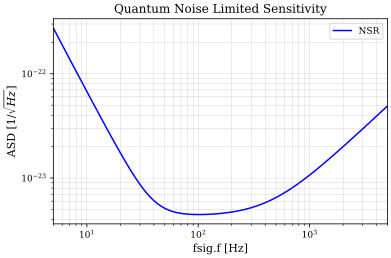

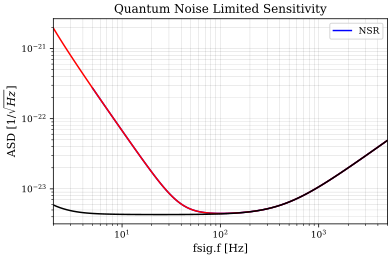

In [7]:
# quick default plot
virgo.plot_QNLS()

# with custom x-axis
virgo.plot_QNLS(axis=[5, 5000, 100])

# get_QNLS() returns a Solution which contains more information
# see documentation: https://finesse.docs.ligo.org/finesse3/api/solutions/array/finesse.solutions.array.ArraySolution.html
out = virgo.get_QNLS(axis=[2, 5000, 100])
plt.loglog(out.x1, out['NSR_with_RP'], out.x1, out['NSR_without_RP'])

## Ex. 6: Plot the DARM transfer function

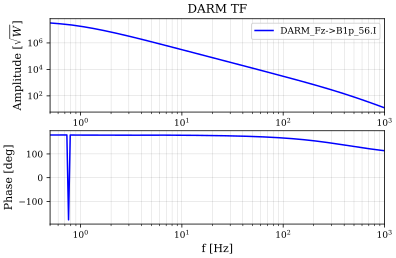

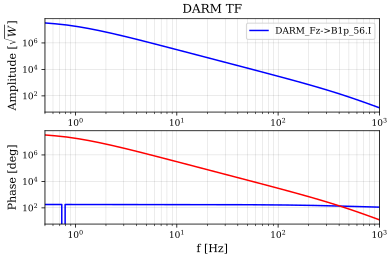

In [8]:
# quick default plot
virgo.plot_DARM()

# with custom x-axis
virgo.plot_DARM(axis=[0.5, 1000, 200])

# get_DARM() returns a Solution which contains more information
# see documentation: https://finesse.docs.ligo.org/finesse3/api/solutions/array/finesse.solutions.array.ArraySolution.html
out = virgo.get_DARM(axis=[0.5, 1000, 200])
H = out.out[:, 0, 0].squeeze()
plt.loglog(out.f, abs(H))

## Ex. 7: Plot DoF scans

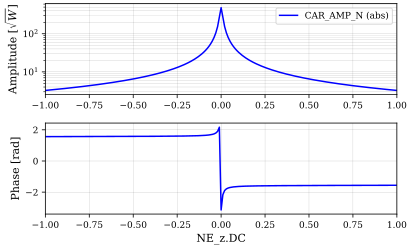

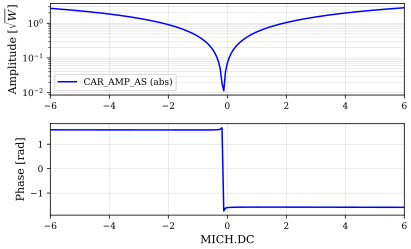

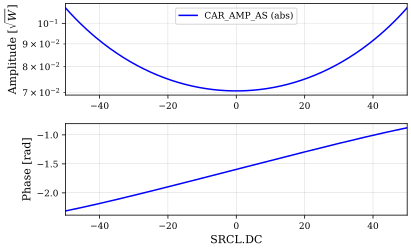

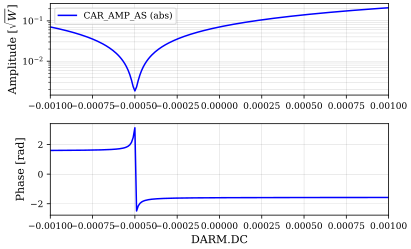

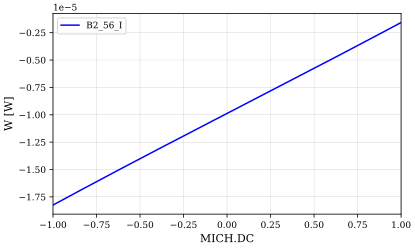

<ArraySolution of xaxis @ 0x7e703873a080 children=0>

In [9]:
# see power in North arm when tuning end mirror
virgo.dof_plot('NE_z', "CAR_AMP_N")

# watch behavior of anti-symmetric port for different dofs
virgo.dof_plot('MICH', "CAR_AMP_AS", xscale=6)
virgo.dof_plot('SRCL', "CAR_AMP_AS", xscale=50)
virgo.dof_plot('DARM', "CAR_AMP_AS", xscale=0.001)

# plot MICH error signal
virgo.dof_plot('MICH', 'B2_56_I', xscale=1, logy=False)

# Useful print outs

In [10]:
virgo.print_lengths()
virgo.print_powers()
virgo.print_tunings()
virgo.print_settings()
virgo.print_dofs()
virgo.print_thermal_values()

┌─────────────────────────────────────────────────┐
│- Arm lengths [m]:                               │
│  LN   = 2999.8180   LW = 2999.7880              │
├─────────────────────────────────────────────────┤
│- Michelson and recycling lengths [m]:           │
│  ln   = 6.0152      lw       = 5.7851           │
│  lpr  = 6.0518      lsr      = 6.0518           │
│  lMI  = 5.9001      lSchnupp = 0.2301           │
│  lPRC = 11.9520     lSRC     = 11.9520          │
├─────────────────────────────────────────────────┤
│- Associated cavity frequencies [Hz]:            │
│  fsrN   = 49968.44    fsrW   = 49968.94         │
│  fsrPRC = 12541554.00 fsrSRC = 12541554.00      │
│                                                 │
│- Modulation sideband frequencies [MHz]:         │
│  f6     = 6.270777     f8     = 8.361036        │
│  f56     = 56.436993                            │
├─────────────────────────────────────────────────┤
│- Check frequency match [MHz]:                   │
│  125.5*fsr